The following is from [this article](https://medium.com/towards-data-science/chat-with-your-dataset-using-bayesian-inferences-bfd4dc7f8dcd) in Medium.

*With the rise of chatGPT-like models, it has become accessible for a broader audience to analyze your own data set and, so to speak, “ask questions”. Although this is great, such an approach has also disadvantages when using it as an analytical step in automated pipelines. This is especially the case when the outcome of models can have a significant impact. To maintain control and ensure results are accurate we can also use Bayesian inferences to talk to our data set. In this blog, we will go through the steps on how to learn a Bayesian model and apply do-calculus on the data science salary data set. I will demonstrate how to create a model that allows you to “ask questions” to your data set and maintain control. You will be surprised by the ease of creating such a model using the [bnlearn library](https://erdogant.github.io/bnlearn/pages/html/index.html).*

# Introduction

Extracting valuable insights from data sets is an ongoing challenge for data scientists and analysts. ChatGPT-like models have made it easier to interactively analyze data sets but at the same time, it can become less transparent and even unknown why choices are made. Relying on such black-box approaches is far from ideal in automated analytical pipelines. Creating transparent models is especially important when the outcome of a model is impactful on the actions that are taken.

In the next sections, I will first introduce the [bnlearn library](https://erdogant.github.io/bnlearn/pages/html/index.html) on how to learn causal networks. Then I will demonstrate how to learn causal networks using a mixed data set, and how to apply do-calculus to effectively query the data set. Let’s see how Bayesian inference can help us to interact with our data sets!

# The Bnlearn library

**Bnlearn** is a powerful Python package that provides a comprehensive set of functions for causal analysis using Bayesian Networks. It can handle both discrete, mixed, and continuous data sets, and offers a wide range of user-friendly functionalities for causal learning, including structure learning, parameter learning, and making inferences. Before we can make inferences, we need to understand structure learning and parameter learning because it relies on both learnings.

**Learning the causal structure** of a data set is one of the great features of bnlearn. Structure learning eliminates the need for prior knowledge or assumptions about the underlying relationships between variables. There are three approaches in bnlearn to learn a causal model and capture the dependencies between variables. Structure learning will result in a so-called Directed Acyclic Graph or DAG). Although all three techniques will result in a causal DAG, some can handle a large number of features while others have higher accuracy. 

- Score-based structure learning: Using scoring functions BIC, BDeu, k2, bds, aic, in combination with search strategies such as exhaustivesearch, hillclimbsearch, chow-liu, Tree-augmented Naive Bayes (TAN), NaiveBayesian.
- Constraint-based structure learning (PC): Using statistics such chi-square test to test for edge strengths prior the modeling.
- Hybrid structure learning: (the combination of both techniques)
- Score-based, Constraint-based, and Hybrid structure learning. Although all three techniques will result in a causal DAG, some can handle a large number of features while others have higher accuracy.

**Parameter learning** is the second important part of Bayesian network analysis, and bnlearn excels in this area as well. By leveraging a set of data samples and a (pre-determined) DAG we can estimate the Conditional Probability Distributions or Tables (CPDs or CPTs). 

Bnlearn also provided a plethora of functions and helper utilities to assist users throughout the analysis process. These include data set transformation functions, topological ordering derivation, graph comparison tools, insightful interactive plotting capabilities, and more. The bnlearn library supports loading bif files, converting directed graphs to undirected ones, and performing statistical tests for assessing independence among variables.

In the next section, we will jump into making inferences using do-calculus with hands-on examples. This allows us to ask questions to our data set. As mentioned earlier, structure learning and parameter learning form the basis.

# Interrogating data sets requires making inferences using do-calculus.

When we make inferences using do-calculus, it basically means that we can query the data set and “ask questions” to the data. To do this, we need two main ingredients: the DAG and the CPTs that are assigned to each node in the graph. The CPTs contain the probabilities of each variable and capture the causal relationships given to its parents. Let’s move on and create an example where we can see how it really works.

# Application with the Data Science Salary Dataset

For demonstration, we will use the [data science salary data set](https://ai-jobs.net/salaries/download/) that is derived from ai-jobs.net. The salary data set is collected worldwide and contains 11 features for 4134 samples. If we load the data, we can explore the columns and set features as continuous or category. Note that the model complexity increases with the number of categories which means that more data and computation time is required to determine a causal DAG.

In [1]:
import bnlearn as bn
import datazets as dz
import numpy as np

In [2]:
# Get the data science salary data set
df = dz.get("ds_salaries")

[datazets] >INFO> Import dataset [ds_salaries]


In [3]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,MI,FT,AWS Data Architect,258000,USD,258000,US,100,US,L
1,2023,SE,FT,Data Scientist,225000,USD,225000,US,0,US,M
2,2023,SE,FT,Data Scientist,156400,USD,156400,US,0,US,M
3,2023,SE,FT,Data Engineer,190000,USD,190000,US,100,US,M
4,2023,SE,FT,Data Engineer,150000,USD,150000,US,100,US,M
...,...,...,...,...,...,...,...,...,...,...,...
4129,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
4130,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
4131,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
4132,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [4]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [5]:
# 'work_year'          > The year the salary was paid.
# 'experience_level'   > The experience level in the job during the year.
# 'employment_type'    > Type of employment: Part-time, full time, contract or freelance.
# 'job_title'          > Name of the role.
# 'employee_residence' > Primary country of residence.
# 'remote_ratio'       > Remote work: less than 20%, partially, more than 80%
# 'company_location'   > Country of the employer's main office.
# 'company_size'       > Average number of people that worked for the company during the year.
# 'salary'             > Total gross salary amount paid.
# 'salary_currency'    > Currency of the salary paid (ISO 4217 code).
# 'salary_in_usd'      > Converted salary in USD.

# Complexity is a major limitation

When features contain many categories, the complexity grows exponentially with the number of parent nodes associated with that table. In other words, when you increase the number of categories, it requires a lot more data to gain reliable results. Think about it like this: when you split the data into categories, the number of samples within a single category will become smaller after each split. The low number of samples per category directly affects the statistical power. In our example, we have a feature `job_title` that contains 99 unique titles for which 14 job titles (such as data scientists) contain 25 samples or more. The remaining 85 job titles are either unique or seen only a few times. To make sure this feature is not removed by the model because lack of statistical power, we need to aggregate some of the job titles. In the code section below we will aggregate job titles into 7 main categories. This results in categories that have enough samples for Bayesian modeling.

In [6]:
df["job_title"].unique()

array(['AWS Data Architect', 'Data Scientist', 'Data Engineer',
       'Applied Scientist', 'ML Engineer', 'Data Analyst',
       'Machine Learning Engineer', 'Data Manager',
       'Product Data Analyst', 'Autonomous Vehicle Operations Lead',
       'Applied Machine Learning Engineer', 'Analytics Engineer',
       'ETL Developer', 'Business Intelligence Engineer',
       'BI Data Analyst', 'Machine Learning Developer',
       'Research Engineer', 'Data Integration Specialist',
       'Data Architect', 'BI Developer', 'Data Visualization Analyst',
       'Head of Data', 'Autonomous Vehicle Technician', 'Data Modeler',
       'Sales Data Analyst', 'Cloud Data Engineer',
       'Finance Data Analyst', 'Research Scientist',
       'Data Analytics Manager', 'Data Specialist',
       'Data Operations Analyst', 'Director of Data Science',
       'Data Science Manager', 'Data Science Lead',
       'Machine Learning Scientist', 'AI Scientist',
       'Computer Vision Engineer', 'Data Science C

In [7]:
df["job_title"].nunique()

99

In [8]:
# Group similar job titles
titles = [
    [
        "data scientist",
        "data science",
        "research",
        "applied",
        "specialist",
        "ai",
        "machine learning",
    ],
    ["engineer", "etl"],
    ["analyst", "bi", "business", "product", "modeler", "analytics"],
    ["manager", "head", "director"],
    ["architect", "cloud", "aws"],
    ["lead/principal", "lead", "principal"],
]

In [9]:
# Aggregate job titles
job_title = df["job_title"].str.lower().copy()

In [10]:
job_title

0             aws data architect
1                 data scientist
2                 data scientist
3                  data engineer
4                  data engineer
                  ...           
4129              data scientist
4130    principal data scientist
4131              data scientist
4132       business data analyst
4133        data science manager
Name: job_title, Length: 4134, dtype: object

In [11]:
df["job_title"] = "Other"

In [12]:
# Store the new names
for t in titles:
    for name in t:
        df["job_title"][list(map(lambda x: name in x, job_title))] = t[0]

In [13]:
df["job_title"].value_counts()

engineer          1654
data scientist    1238
analyst            902
manager            158
architect          118
lead/principal      55
Other                9
Name: job_title, dtype: int64

The next pre-processing step is to rename some of the feature names. In addition, we will also add a new feature that describes whether the company was located in USA or Europe, and remove some redundant variables, such as `salary_currency` and `salary`.

In [14]:
# Rename catagorical variables for better understanding
df["experience_level"] = df["experience_level"].replace(
    {
        "EN": "Entry-level",
        "MI": "Junior Mid-level",
        "SE": "Intermediate Senior-level",
        "EX": "Expert Executive-level / Director",
    },
    regex=True,
)
df["employment_type"] = df["employment_type"].replace(
    {"PT": "Part-time", "FT": "Full-time", "CT": "Contract", "FL": "Freelance"},
    regex=True,
)
df["company_size"] = df["company_size"].replace(
    {"S": "Small (less than 50)", "M": "Medium (50 to 250)", "L": "Large (>250)"},
    regex=True,
)
df["remote_ratio"] = df["remote_ratio"].replace(
    {0: "No remote", 50: "Partially remote", 100: ">80% remote"}, regex=True
)

In [15]:
# Add new feature
df["country"] = "USA"
countries_europe = [
    "SM",
    "DE",
    "GB",
    "ES",
    "FR",
    "RU",
    "IT",
    "NL",
    "CH",
    "CF",
    "FI",
    "UA",
    "IE",
    "GR",
    "MK",
    "RO",
    "AL",
    "LT",
    "BA",
    "LV",
    "EE",
    "AM",
    "HR",
    "SI",
    "PT",
    "HU",
    "AT",
    "SK",
    "CZ",
    "DK",
    "BE",
    "MD",
    "MT",
]
df["country"][np.isin(df["company_location"], countries_europe)] = "europe"

In [16]:
# Remove redundant variables
salary_in_usd = df["salary_in_usd"]
df.drop(labels=["salary_currency", "salary"], inplace=True, axis=1)

As a final step, we need to discretize `salary_in_usd` which can be done manually or using the `discretizer` function in bnlearn. For demonstration purposes, let’s do both. For the latter case, we assume that salary depends on `experience_level` and on the `country`. Based on these input variables, the salary is then partitioned into bins (see code section below).

In [17]:
# Discretize the salary feature.
discretize_method = "manual"

In [18]:
# Discretize Manually
if discretize_method == "manual":
    # Set salary
    df["salary_in_usd"] = None
    df["salary_in_usd"].loc[salary_in_usd < 80000] = "<80K"
    df["salary_in_usd"].loc[
        np.logical_and(salary_in_usd >= 80000, salary_in_usd < 100000)
    ] = "80-100K"
    df["salary_in_usd"].loc[
        np.logical_and(salary_in_usd >= 100000, salary_in_usd < 160000)
    ] = "100-160K"
    df["salary_in_usd"].loc[
        np.logical_and(salary_in_usd >= 160000, salary_in_usd < 250000)
    ] = "160-250K"
    df["salary_in_usd"].loc[salary_in_usd >= 250000] = ">250K"
else:
    # Discretize automatically but with prior knowledge.
    tmpdf = df[["experience_level", "salary_in_usd", "country"]]
    # Create edges
    edges = [("experience_level", "salary_in_usd"), ("country", "salary_in_usd")]
    # Create DAG based on edges
    DAG = bn.make_DAG(edges)
    bn.plot(DAG)
    # Discretize the continous columns
    df_disc = bn.discretize(tmpdf, edges, ["salary_in_usd"], max_iterations=1)
    # Store
    df["salary_in_usd"] = df_disc["salary_in_usd"]
    # Print
    print(df["salary_in_usd"].value_counts())

# The Final DataFrame

The final data frame has 10 features with 4134 samples. Each feature is a categorical feature with two or multiple states. This data frame is going to be the input to learn the structure and determine the causal DAG.

In [19]:
df

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,country
0,2023,Junior Mid-level,Full-time,architect,>250K,US,>80% remote,US,Large (>250),USA
1,2023,Intermediate Senior-level,Full-time,data scientist,160-250K,US,No remote,US,Medium (50 to 250),USA
2,2023,Intermediate Senior-level,Full-time,data scientist,100-160K,US,No remote,US,Medium (50 to 250),USA
3,2023,Intermediate Senior-level,Full-time,engineer,160-250K,US,>80% remote,US,Medium (50 to 250),USA
4,2023,Intermediate Senior-level,Full-time,engineer,100-160K,US,>80% remote,US,Medium (50 to 250),USA
...,...,...,...,...,...,...,...,...,...,...
4129,2020,Intermediate Senior-level,Full-time,data scientist,>250K,US,>80% remote,US,Large (>250),USA
4130,2021,Junior Mid-level,Full-time,lead/principal,100-160K,US,>80% remote,US,Large (>250),USA
4131,2020,Entry-level,Full-time,data scientist,100-160K,US,>80% remote,US,Small (less than 50),USA
4132,2020,Entry-level,Contract,analyst,100-160K,US,>80% remote,US,Large (>250),USA


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4134 entries, 0 to 4133
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           4134 non-null   int64 
 1   experience_level    4134 non-null   object
 2   employment_type     4134 non-null   object
 3   job_title           4134 non-null   object
 4   salary_in_usd       4134 non-null   object
 5   employee_residence  4134 non-null   object
 6   remote_ratio        4134 non-null   object
 7   company_location    4134 non-null   object
 8   company_size        4134 non-null   object
 9   country             4134 non-null   object
dtypes: int64(1), object(9)
memory usage: 323.1+ KB


In [21]:
for col in df.columns:
    print(col, df[col].nunique())

work_year 4
experience_level 4
employment_type 4
job_title 7
salary_in_usd 5
employee_residence 80
remote_ratio 3
company_location 74
company_size 3
country 2


# Bayesian Structure Learning to estimate the DAG.

At this point, we have pre-processed the data set and we are ready to learn the causal structure. There are six algorithms implemented in bnlearn that can help with this task. We need to choose a method for which we do not need to have a target variable, and it needs to handle many categories. The available search strategies are:

- **The hillclimbsearch** algorithm is a heuristic search method. It starts with an empty network and iteratively adds or removes edges based on a scoring metric. The algorithm explores different network structures and selects the one with the highest score.

- **The exhaustivesearch** performs an exhaustive search over all possible network structures to find the optimal Bayesian network. It evaluates and scores each structure based on a specified scoring metric. While this method guarantees finding the best network structure, it can be computationally expensive for large networks due to the exponential growth of possibilities.

- **The constraintsearch** incorporates user-specified constraints or expert knowledge into the structure learning process of a Bayesian network. It uses these constraints to guide the search and restrict the space of possible network structures, ensuring that the learned network adheres to the specified constraints.

- **The chow-liu** algorithm is a method for learning the structure of a tree-structured Bayesian network. It calculates the mutual information between each pair of variables and constructs a tree by greedily selecting the edges that maximize the total mutual information of the network. This algorithm is efficient and widely used for learning the structure of discrete Bayesian networks but requires setting a root node.

- **The naivebayes** algorithm assumes that all features in a dataset are conditionally independent given the class variable. It learns the conditional probability distribution of each feature given the class and uses Bayes theorem to calculate the posterior probability of the class given the features. Despite its naive assumption, this algorithm is often used in classification tasks and can be efficient for large datasets.

- **The TAN** (Tree-Augmented Naive Bayes) algorithm is an extension of the naive Bayes algorithm that allows for dependencies among the features, given the class variable. It learns a tree structure that connects the features and uses this structure to model the conditional dependencies. TAN combines the simplicity of naive Bayes with some modeling power, making it a popular choice for classification tasks with correlated features. This method requires setting a class node.

The scoring types BIC, K2, BDS, AIC, and BDEU are used to evaluate and compare different network structures. As an example, BIC balances the model complexity and data fit, while the others consider different types of prior probabilities. In addition, the independence test prunes the spurious edges from the model. In our use case, I will use the hillclimbsearch method with scoring type BIC for structure learning. We will not define a target value but let the bnlearn decide the entire causal structure of the data itself.

In [22]:
# Structure learning
model = bn.structure_learning.fit(df, methodtype="hc", scoretype="bic")

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


In [23]:
# independence test
model = bn.independence_test(model, df, prune=False)

[bnlearn] >Compute edge strength with [chi_square]


In [24]:
# Parameter learning to learn the CPTs. This step is required to make inferences.
model = bn.parameter_learning.fit(model, df, methodtype="bayes")

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of work_year:
+-----------------+-------------------------+-----+---------------------+----------------------+
| salary_in_usd   | salary_in_usd(100-160K) | ... | salary_in_usd(<80K) | salary_in_usd(>250K) |
+-----------------+-------------------------+-----+---------------------+----------------------+
| work_year(2020) | 0.03852504127682994     | ... | 0.10064935064935066 | 0.13033175355450238  |
+-----------------+-------------------------+-----+---------------------+----------------------+
| work_year(2021) | 0.05393505778756191     | ... | 0.1764069264069264  | 0.13507109004739337  |
+-----------------+-------------------------+-----+---------------------+----------------------+
| work_year(2022) | 0.40286186020913595     | ... | 0.3906926406926407  | 0.22274881516587677  |
+

[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


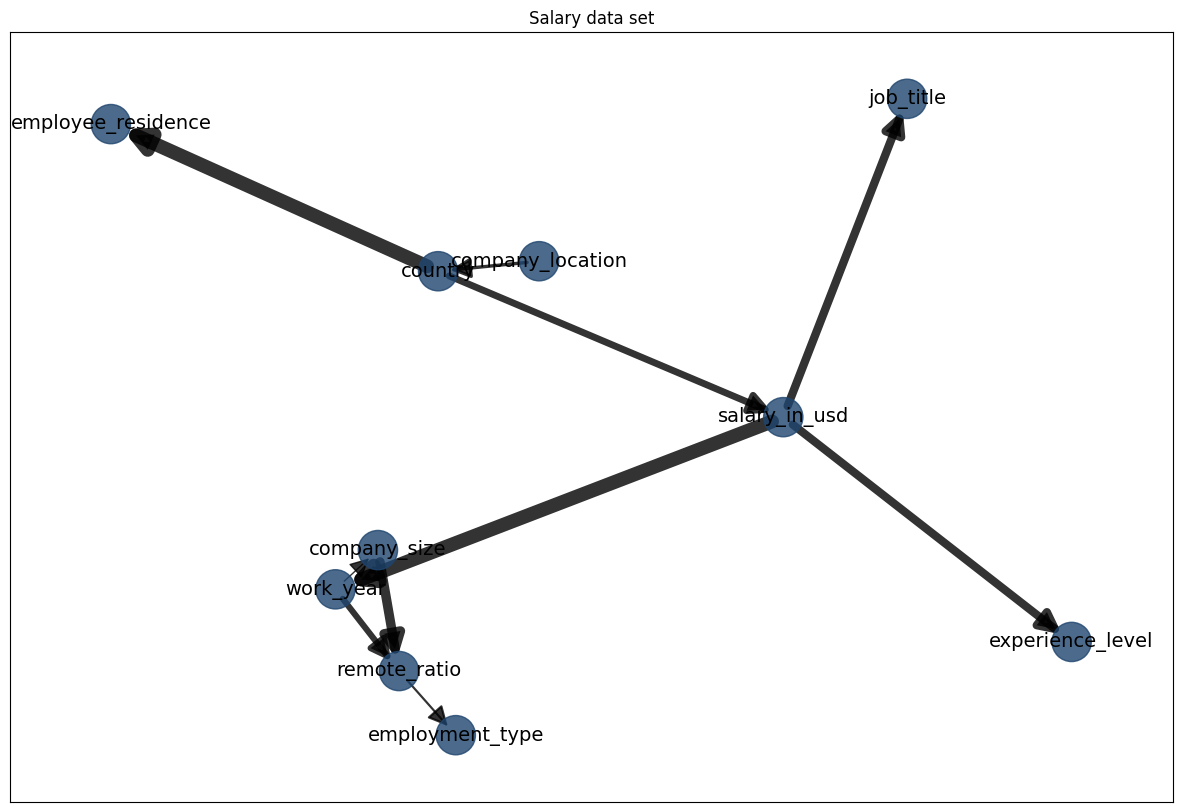

{'fig': <Figure size 1500x1000 with 1 Axes>,
 'ax': <Figure size 1500x1000 with 1 Axes>,
 'pos': {'work_year': array([-0.27008605, -0.45471349]),
  'experience_level': array([ 0.69327984, -0.61069872]),
  'employment_type': array([-0.11259779, -0.88722599]),
  'job_title': array([0.47805353, 1.        ]),
  'salary_in_usd': array([0.31595306, 0.05590017]),
  'employee_residence': array([-0.56393648,  0.92498676]),
  'remote_ratio': array([-0.18694295, -0.69703466]),
  'company_location': array([-0.00354287,  0.51837511]),
  'company_size': array([-0.21446707, -0.33830249]),
  'country': array([-0.13571321,  0.48871332])},
 'G': <networkx.classes.digraph.DiGraph at 0x156b2c3bdc0>,
 'node_properties': {'work_year': {'node_color': '#1f456e', 'node_size': 800},
  'experience_level': {'node_color': '#1f456e', 'node_size': 800},
  'employment_type': {'node_color': '#1f456e', 'node_size': 800},
  'job_title': {'node_color': '#1f456e', 'node_size': 800},
  'salary_in_usd': {'node_color': '#1f4

In [25]:
# Plot
bn.plot(model, title="Salary data set")

In [26]:
bn.plot(model, interactive=True, title="method=hc and score=bic")

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Set directed=True to see the markers!
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Converting adjacency matrix into source-target..
[d3blocks] >INFO> Number of unique nodes: 10
[d3blocks] >INFO> Slider range is set to [0, 10]
[d3blocks] >INFO> Write to path: [C:\Users\johnw\AppData\Local\Temp\tmpngogicjt\d3graph.html]


[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.


[d3blocks] >INFO> File already exists and will be overwritten: [C:\Users\johnw\AppData\Local\Temp\tmpngogicjt\d3graph.html]
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Number of unique nodes: 10
[d3blocks] >INFO> Slider range is set to [0, 10]
[d3blocks] >INFO> Write to path: [C:\Users\johnw\AppData\Local\Temp\tmpg7exufpg\method=hc_and_score=bic.html]
[d3blocks] >INFO> File already exists and will be overwritten: [C:\Users\johnw\AppData\Local\Temp\tmpg7exufpg\method=hc_and_score=bic.html]


{'fig': 'C:\\Users\\johnw\\AppData\\Local\\Temp\\tmpg7exufpg\\method=hc_and_score=bic.html',
 'ax': 'C:\\Users\\johnw\\AppData\\Local\\Temp\\tmpg7exufpg\\method=hc_and_score=bic.html',
 'pos': None,
 'G': <networkx.classes.digraph.DiGraph at 0x156b2d34880>,
 'node_properties': {'work_year': {'node_color': '#1f456e', 'node_size': 10},
  'experience_level': {'node_color': '#1f456e', 'node_size': 10},
  'employment_type': {'node_color': '#1f456e', 'node_size': 10},
  'job_title': {'node_color': '#1f456e', 'node_size': 10},
  'salary_in_usd': {'node_color': '#1f456e', 'node_size': 10},
  'employee_residence': {'node_color': '#1f456e', 'node_size': 10},
  'remote_ratio': {'node_color': '#1f456e', 'node_size': 10},
  'company_location': {'node_color': '#1f456e', 'node_size': 10},
  'company_size': {'node_color': '#1f456e', 'node_size': 10},
  'country': {'node_color': '#1f456e', 'node_size': 10}},
 'edge_properties': {('company_size', 'remote_ratio'): {'color': '#000000',
   'weight': 4.3918

# Chat with Your Data Set

With the learned DAG (Figures 1 and 2), we can estimate the conditional probability distributions (CPTs, see code section below), and make inferences using do-calculus. Let’s start asking questions. Note that the results can (slightly) change based on the stochastic components in the model.

## Question 1

> What is the probability of a job title given that you work in a large comany? `P(job_title | company_size=Large (>250))`

After running the code section below we can see that engineer is the most likely outcome (`P=0.34`) followed by data scientist (`P=0.26`).

In [27]:
query = bn.inference.fit(
    model, variables=["job_title"], evidence={"company_size": "Large (>250)"}
)

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+----------------+-----------+
|    | job_title      |         p |
+====+================+===========+
|  0 | Other          | 0.031616  |
+----+----------------+-----------+
|  1 | analyst        | 0.209212  |
+----+----------------+-----------+
|  2 | architect      | 0.0510425 |
+----+----------------+-----------+
|  3 | data scientist | 0.265006  |
+----+----------------+-----------+
|  4 | engineer       | 0.343216  |
+----+----------------+-----------+
|  5 | lead/principal | 0.0407967 |
+----+----------------+-----------+
|  6 | manager        | 0.0591106 |
+----+----------------+-----------+


# Question 2

> What is the probability of a salary range given a full time employment type, partially remote work, have the data science function at entry level and live in germany (DE)?

In the results below we can see our five salary categories for which the strongest posterior probability `P=0.7` is a salary of <80K under these conditions. Note that other salaries also occur but they happen less frequently.

By changing the variables and evidence we can ask all kinds of questions. For example, we can now change experience level, residence, job title, etc, and determine how the probabilities are changing.

In [28]:
query = bn.inference.fit(
    model,
    variables=["salary_in_usd"],
    evidence={
        "employment_type": "Full-time",
        "remote_ratio": "Partially remote",
        "job_title": "data scientist",
        "employee_residence": "DE",
        "experience_level": "Entry-level",
    },
)

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+-----------+
|    | salary_in_usd   |         p |
+====+=================+===========+
|  0 | 100-160K        | 0.0664068 |
+----+-----------------+-----------+
|  1 | 160-250K        | 0.0424349 |
+----+-----------------+-----------+
|  2 | 80-100K         | 0.117463  |
+----+-----------------+-----------+
|  3 | <80K            | 0.707087  |
+----+-----------------+-----------+
|  4 | >250K           | 0.0666078 |
+----+-----------------+-----------+


# Question by myself

In [29]:
df["experience_level"].unique()

array(['Junior Mid-level', 'Intermediate Senior-level', 'Entry-level',
       'Expert Executive-level / Director'], dtype=object)

In [30]:
query = bn.inference.fit(
    model,
    variables=["salary_in_usd"],
    evidence={
        "employment_type": "Full-time",
        "job_title": "data scientist",
        "employee_residence": "US",
        "experience_level": "Intermediate Senior-level",
    },
)

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+-----------+
|    | salary_in_usd   |         p |
+====+=================+===========+
|  0 | 100-160K        | 0.413788  |
+----+-----------------+-----------+
|  1 | 160-250K        | 0.437108  |
+----+-----------------+-----------+
|  2 | 80-100K         | 0.0408264 |
+----+-----------------+-----------+
|  3 | <80K            | 0.0570524 |
+----+-----------------+-----------+
|  4 | >250K           | 0.0512247 |
+----+-----------------+-----------+


# Final words.

In this blog, we learned how to create a Bayesian model and how to ask questions to a mixed data set using inferences with do-calculus. With the use of bnlearn it becomes straightforward to setup such models and the models offer understandable and explainable results that can be easily embedded in data science pipelines.